# 1 load data

In [1]:
import imp
import numpy as np
data_process=imp.load_source('data_process','../data_process.py')
from data_process import get_xml_data

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
train_sents,train_contexts,train_labels=get_xml_data('../SMP2019/SMP2019_ECISA_Train.xml')
validation_sents,validation_contexts,validation_labels=get_xml_data('../SMP2019/SMP2019_ECISA_Dev.xml')

In [4]:
from transformers import BertModel,BertTokenizer

/home/xuke/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xuke/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xuke/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xuke/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [5]:
bert_name='hfl/chinese-bert-wwm'

In [6]:
bert = BertModel.from_pretrained(bert_name, return_dict=False)
tokenizer = BertTokenizer.from_pretrained(bert_name)

In [7]:
from keras.preprocessing.sequence import pad_sequences
import torch

Using TensorFlow backend.


In [8]:
def get_bertTensor(text_list,MAX_LEN = 128):
    words_idx = []
    for sent in text_list:
        encoded_sent = tokenizer.encode(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LEN,          # Truncate all sentences.
                            #return_tensors = 'pt',     # Return pytorch tensors.
                       )
        
        words_idx.append(encoded_sent)
    
    words_idx=pad_sequences(words_idx, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    words_masks=[]
    for sent in words_idx:
        att_mask = [int(token_id > 0) for token_id in sent]
        words_masks.append(att_mask)
        
    return torch.tensor(words_idx),torch.tensor(words_masks)

In [9]:
train_sents,train_sents_masks=get_bertTensor(train_sents)
train_contexts,train_contexts_masks=get_bertTensor(train_contexts,MAX_LEN=256)
train_labels=torch.tensor(train_labels)

validation_sents,validation_sents_masks=get_bertTensor(validation_sents)
validation_contexts,validation_contexts_masks=get_bertTensor(validation_contexts,MAX_LEN=256)
validation_labels=torch.tensor(validation_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [11]:
batch_size = 6
train_data = TensorDataset(train_sents,train_sents_masks,train_contexts,train_contexts_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_sents,validation_sents_masks,validation_contexts,
                                validation_contexts_masks,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 2 AEN_Bert

In [12]:
from layers.dynamic_rnn import DynamicLSTM
from layers.squeeze_embedding import SqueezeEmbedding
from layers.attention import Attention, NoQueryAttention
from layers.point_wise_feed_forward import PositionwiseFeedForward
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class AEN_BERT(nn.Module):
    def __init__(self,bert):
        super(AEN_BERT, self).__init__()

        dropout=0.1
        bert_dim=768    
        hidden_dim=300
        polarities_dim=3
        
        self.drop_path_prob=0.0
        self.bert=bert
        self.dropout = nn.Dropout(dropout)
        self.attn_k = Attention(bert_dim, out_dim=hidden_dim, n_head=8, score_function='mlp', dropout=dropout)
        self.attn_q = Attention(bert_dim, out_dim=hidden_dim, n_head=8, score_function='mlp', dropout=dropout)
        self.ffn_c = PositionwiseFeedForward(hidden_dim, dropout=dropout)
        self.ffn_t = PositionwiseFeedForward(hidden_dim, dropout=dropout)

        self.attn_s1 = Attention(hidden_dim, n_head=8, score_function='mlp', dropout=dropout)
        self.dense = nn.Linear(hidden_dim*2, polarities_dim)
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self, inputs):
#         context, target = inputs[0], inputs[1]
        context_len=128
        target_len=128
        
        target,_=bert(a_input_ids, token_type_ids=None, attention_mask=a_input_mask,)
        context,_=bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,)
#         context_len = torch.sum(context != 0, dim=-1)
#         target_len = torch.sum(target != 0, dim=-1)
#         context = self.squeeze_embedding(context, context_len)
#         context, _ = self.bert(context)
        context = self.dropout(context)
        target = self.dropout(target)

        hc, _ = self.attn_k(context, context)
        hc = self.ffn_c(hc)
#         ht, _ = self.attn_q(context, target)
        ht, _ = self.attn_q(target, target)
        ht = self.ffn_t(ht)

        s1, _ = self.attn_s1(hc, ht)

        hc_mean = torch.div(torch.sum(hc, dim=1), context_len)
        ht_mean = torch.div(torch.sum(ht, dim=1), target_len)
        s1_mean = torch.div(torch.sum(s1, dim=1), context_len)

        x = torch.cat(( s1_mean, ht_mean), dim=-1)
        
        out=self.dense(x)
#         out = torch.argmax(self.softmax(self.dense(x)),dim=1)
        return out

# 3 Train

In [14]:
import random
import sys
import os
import time
import logging
import datetime
from sklearn.metrics import classification_report,f1_score

In [15]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [16]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
# model = torch.nn.DataParallel(model, device_ids=[0,2,3]).cuda()

In [17]:
if torch.cuda.is_available():     
    device = torch.device("cuda:0")#select gpu

In [18]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [19]:
# bert.cuda()
model=AEN_BERT(bert)
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [20]:
loss_plot,acc_plot=[],[]

In [21]:
loss_values = []
epochs=4
for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    t0 = time.time()
#     total_loss=0
    model.train()
    n_correct, n_total, loss_total = 0, 0, 0
    for step,batch in enumerate(train_dataloader):

        a_input_ids  = batch[0].to(device)
        a_input_mask = batch[1].to(device)
        b_input_ids  = batch[2].to(device)
        b_input_mask = batch[3].to(device)
        labels       = batch[4].to(device)
        
        optimizer.zero_grad()
            
        inputs=a_input_ids,a_input_mask,b_input_ids,b_input_mask 
        predict=model(inputs)
        loss=criterion(predict,labels)
#         print(predict,labels,loss)
#         total_loss+=loss
        loss.backward()
        optimizer.step()
        
        n_correct += (torch.argmax(predict, -1) == labels).sum().item()
        n_total += len(predict)
        loss_total += loss.item() * len(predict)
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))        
            train_acc = n_correct / n_total
            train_loss = loss_total / n_total
            loss_plot.append(train_loss)
            acc_plot.append(train_acc)
            logger.info('loss: {:.4f}, acc: {:.4f}'.format(train_loss, train_acc))   
            n_correct, n_total, loss_total = 0, 0, 0
            
    true_labels,predict_labels=[],[]        
    for batch in validation_dataloader:
        a_input_ids  = batch[0].to(device)
        a_input_mask = batch[1].to(device)
        b_input_ids  = batch[2].to(device)
        b_input_mask = batch[3].to(device)
        labels       = batch[4]
        inputs=a_input_ids,a_input_mask,b_input_ids,b_input_mask
        with torch.no_grad():        
            outputs = model(inputs)        
        predict=outputs.detach().cpu().numpy()
        predict=np.argmax(predict, axis=1).flatten()
        predict_labels.append(predict)
        true_labels.append(labels)
    true_labels=[y for x in true_labels for y in x]
    predict_labels=[y for x in predict_labels for y in x]
#     f1_score=f1_score(true_labels,predict_labels,average='weighted')
    print(classification_report(true_labels,predict_labels))
#     print(f1_score)


======== Epoch 1 / 4 ========
Training...


/home/xuke/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  Batch    40  of  2,463.    Elapsed: 0:00:12.
loss: 1.0146, acc: 0.5000
  Batch    80  of  2,463.    Elapsed: 0:00:24.
loss: 0.8559, acc: 0.5875
  Batch   120  of  2,463.    Elapsed: 0:00:36.
loss: 0.8181, acc: 0.6542
  Batch   160  of  2,463.    Elapsed: 0:00:47.
loss: 0.7624, acc: 0.6458
  Batch   200  of  2,463.    Elapsed: 0:00:59.
loss: 0.6524, acc: 0.7417
  Batch   240  of  2,463.    Elapsed: 0:01:11.
loss: 0.6453, acc: 0.7500
  Batch   280  of  2,463.    Elapsed: 0:01:23.
loss: 0.5797, acc: 0.7667
  Batch   320  of  2,463.    Elapsed: 0:01:35.
loss: 0.5656, acc: 0.7625
  Batch   360  of  2,463.    Elapsed: 0:01:47.
loss: 0.6516, acc: 0.7375
  Batch   400  of  2,463.    Elapsed: 0:01:59.
loss: 0.6248, acc: 0.7458
  Batch   440  of  2,463.    Elapsed: 0:02:11.
loss: 0.5195, acc: 0.8000
  Batch   480  of  2,463.    Elapsed: 0:02:23.
loss: 0.5975, acc: 0.7667
  Batch   520  of  2,463.    Elapsed: 0:02:35.
loss: 0.5401, acc: 0.7583
  Batch   560  of  2,463.    Elapsed: 0:02:47.
loss

In [22]:
len(true_labels)

5143

In [23]:
len(predict_labels)

5143

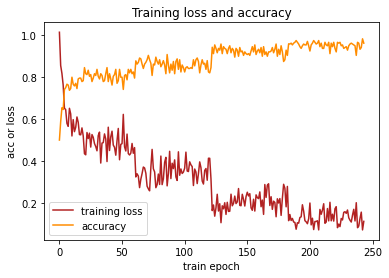

In [24]:
import matplotlib.pyplot as plt

plt.title("Training loss and accuracy") 
plt.xlabel("train epoch") 
plt.ylabel("acc or loss") 
plt.plot(loss_plot, color='firebrick',   label='training loss')
plt.plot(acc_plot,  color='darkorange',   label='accuracy')
plt.legend() 
plt.show()